# Import Data

In [1]:
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta

#start downloading data from 10 years ago
today = datetime.today()
start_date = today - relativedelta(years=10)

data = yf.download('PG', start=start_date)

[*********************100%%**********************]  1 of 1 completed


In [2]:
data = data[['Adj Close']]
data

,Adj Close
Date,
2015-01-02,68.275764
2015-01-05,67.951149
2015-01-06,67.641617
2015-01-07,67.996437
2015-01-08,68.774025
...,...
2024-12-24,168.940002
2024-12-26,170.160004
2024-12-27,169.529999


# Calculate S, stdev and r

#### Risk Free (r)

In [3]:
r = yf.download('^IRX')['Adj Close'].iloc[-1] / 100
r

[*********************100%%**********************]  1 of 1 completed


0.04208000183105469

#### Standard Deviation (stev)

In [4]:
import numpy as np

log_returns = np.log(1 + data.pct_change())

In [5]:
stdev = log_returns.std() * 250 ** 0.5
stdev

Adj Close    0.183833
dtype: float64

In [6]:
type(stdev)

pandas.core.series.Series

In [7]:
# Convert into an array
stdev = stdev.values
stdev

array([0.18383302])

# Calculate Brownian Motion

#### Time to Maturity (T)

In [8]:
start_date = datetime.today()

# Maturity date of the option
end_date = datetime.strptime('25/04/17', '%y/%m/%d')

days_to_maturity = (end_date - start_date).days
days_to_maturity

# T = time in years
T = days_to_maturity / 365
T

0.28493150684931506

#### Trading Days to Maturity (t interval)

In [9]:
# start and end dates need to be in datetime.date format
trading_days_to_maturity = np.busday_count(start_date.date(), end_date.date())

# Prediction for the next x number of trading days until maturity
t_intervals = trading_days_to_maturity
t_intervals

75

#### Delta t

In [10]:
delta_t = T / t_intervals
delta_t

0.0037990867579908677

#### Iterations

In [11]:
# 10000 Different predictions
iterations = 10000

#### Z

In [12]:
Z = np.random.standard_normal((t_intervals + 1, iterations))
Z

array([[-2.07871237, -0.16192876, -0.92279229, ...,  0.8324017 ,
        -0.57155105, -0.47220129],
       [-0.23920334, -0.50601733,  0.01243506, ..., -0.43074118,
        -0.48194003, -2.43806073],
       [ 0.14825812, -2.89239293,  1.04563329, ..., -1.76163901,
         0.42880742, -1.2911886 ],
       ...,
       [ 0.46728944, -0.61344515, -0.33475515, ..., -0.98081886,
        -0.70941945, -2.13333923],
       [-0.81427066, -0.8125896 , -0.41429362, ..., -0.23796124,
         1.24576531,  0.00395915],
       [ 0.66792608,  1.25323487,  1.84688263, ..., -0.18805225,
        -0.08558049,  0.32020506]])

#### S

In [13]:
S = np.zeros_like(Z)
S0 = data.iloc[-1]
S[0] = S0
S

array([[167.6499939, 167.6499939, 167.6499939, ..., 167.6499939,
        167.6499939, 167.6499939],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ]])

# Calculate Euler Discretization

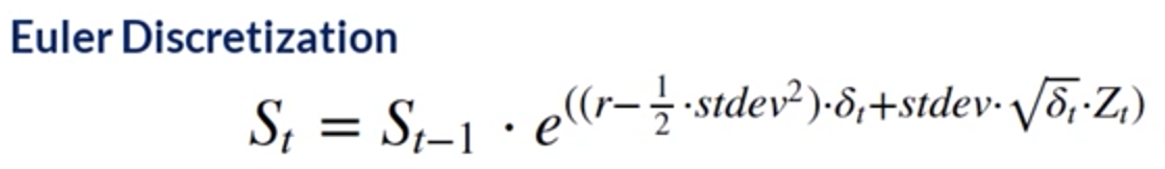

In [14]:
for t in range (1, t_intervals + 1):
    S[t] = S[t-1] * np.exp((r - 0.5 * stdev ** 2) * delta_t + stdev * delta_t ** 0.5 * Z[t])

In [15]:
S

array([[167.6499939 , 167.6499939 , 167.6499939 , ..., 167.6499939 ,
        167.6499939 , 167.6499939 ],
       [167.21221039, 166.70745217, 167.68965976, ..., 166.84970495,
        166.75293895, 163.09759539],
       [167.50937016, 161.34789059, 169.70448667, ..., 163.5679027 ,
        167.58115487, 160.7441791 ],
       ...,
       [185.42462556, 153.45604913, 184.4132058 , ..., 136.90191968,
        163.27355251, 163.522217  ],
       [183.73927097, 152.06415861, 183.56710381, ..., 136.5463502 ,
        165.61044317, 163.54519871],
       [185.15283145, 154.25366717, 187.46698341, ..., 136.26874407,
        165.46575794, 164.1553555 ]])

In [16]:
S.shape

(76, 10000)

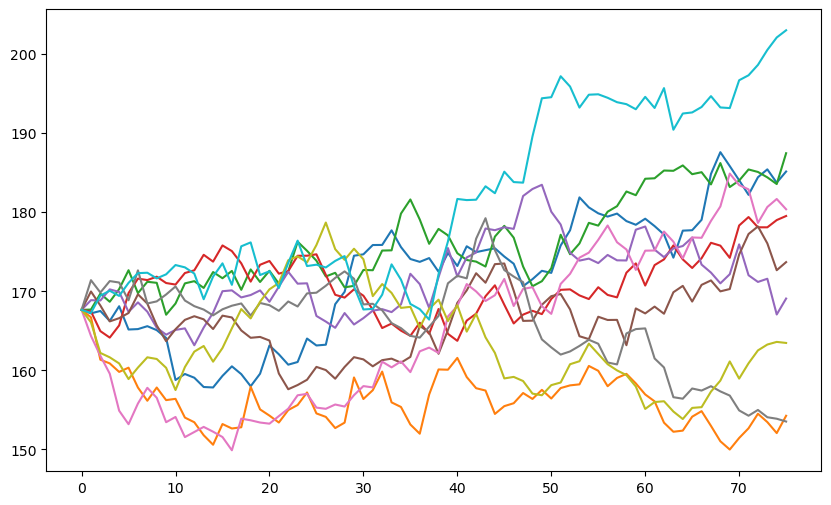

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(S[:, :10]) ;

#### Strike Price (K)

In [18]:
# K = strike price
K = 170

# Calculate Call Option Price

#### Payoff Call Option

In [19]:
# Payoff for Call Option (if stock price lower than strike price, return 0)
p_call = np.maximum(S[-1] - K, 0)
p_call

array([15.15283145,  0.        , 17.46698341, ...,  0.        ,
        0.        ,  0.        ])

In [20]:
# Needs to match number of iterations
p_call.shape

(10000,)

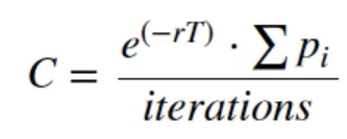

In [21]:
C = np.exp(-r * T) * np.sum(p_call) / iterations
C

6.495326921550215

# Calculate Put Option Price

#### Payoff Put Option

In [22]:
# Payoff for Put Option (if stock price higher than strike price, return 0)
p_put = np.maximum(K - S[-1], 0)
p_put

array([ 0.        , 15.74633283,  0.        , ..., 33.73125593,
        4.53424206,  5.8446445 ])

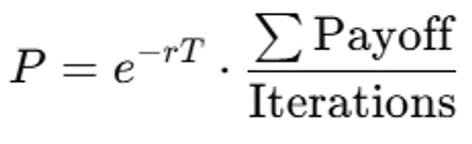

In [23]:
P = np.exp(-r * T) * np.sum(p_put) / iterations
P

6.57822294981328